In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from keras.optimizers import Adam , RMSprop ,SGD ,Adadelta , Adagrad , Adamax  , Nadam

from matplotlib import pyplot
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix


In [10]:
base_skin_dir = os.path.join('..', 'input')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}

In [11]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']


In [12]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
# Reshape image in 3 dimensions (height = 128px, width = 128px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(64, 64, 3))
x_test = x_test.reshape(x_test.shape[0], *(64, 64, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(64, 64, 3))

In [13]:
input_shape = (64, 64, 3)
num_classes = 7

filepath="best_model_LeakyReLU.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [14]:
model_32 = Sequential()
model_32.add(Conv2D(32, kernel_size=(3, 3),activation="relu",padding = 'Same',input_shape=input_shape))
model_32.add(Conv2D(32,kernel_size=(3, 3), activation="relu",padding = 'Same',))
model_32.add(MaxPool2D(pool_size = (2, 2)))
model_32.add(Dropout(0.25))

model_32.add(Conv2D(64, (3, 3), activation="relu",padding = 'Same'))
model_32.add(Conv2D(64, (3, 3), activation="relu",padding = 'Same'))
model_32.add(MaxPool2D(pool_size=(2, 2)))
model_32.add(Dropout(0.40))

model_32.add(Flatten())
model_32.add(Dense(128, activation="relu"))
model_32.add(Dropout(0.5))
model_32.add(Dense(num_classes, activation='softmax'))

optimizer = Adam()
# Compile the model
model_32.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [15]:
epochs = 10 
batch_size = 64
history_32= model_32.fit(x_train,y_train, batch_size=batch_size,validation_data=(x_test,y_test),
                              epochs = epochs,verbose=0)

In [16]:
predictions = model_32.predict(x_test)
y_test_t=np.argmax(y_test)

In [17]:
test_loss, test_acc = model_32.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

2003/2003 [==============================] - 0s 123us/step
Test accuracy: 0.7329006492942794


In [18]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(7), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [19]:
y_test_t=np.argmax(y_test, axis=1)

In [20]:
class_names = ['nv', 'mel', 'Pullover', 'bkl', 'bcc', 
               'akiec', 'vasc', 'df']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


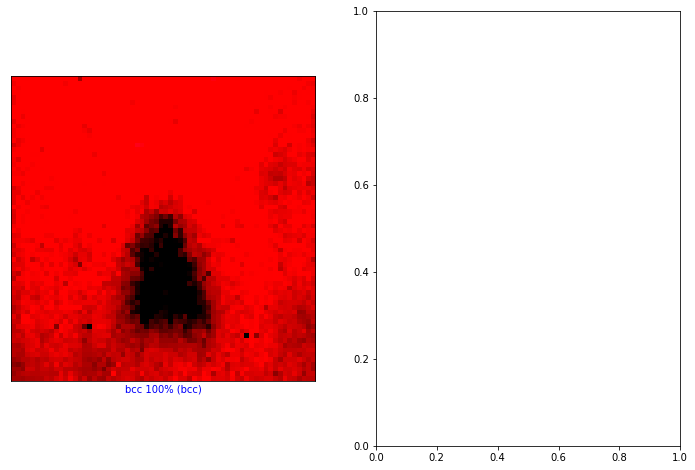

In [21]:
i = 0
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_image(i, predictions, y_test_t, x_test)
plt.subplot(1,2,2)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


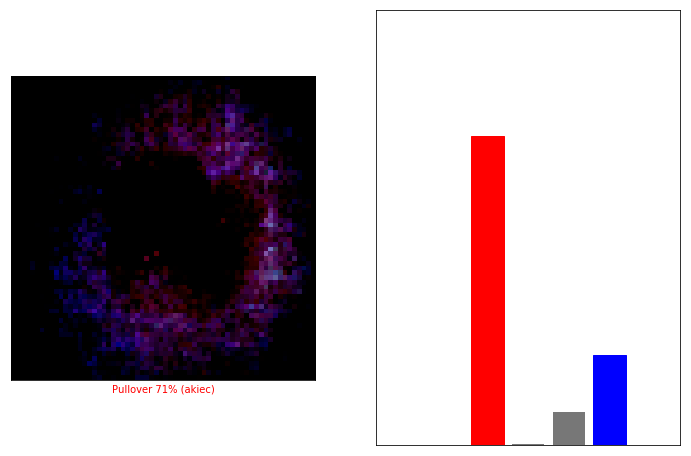

In [22]:
i = 659
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_image(i, predictions, y_test_t, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  y_test_t)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

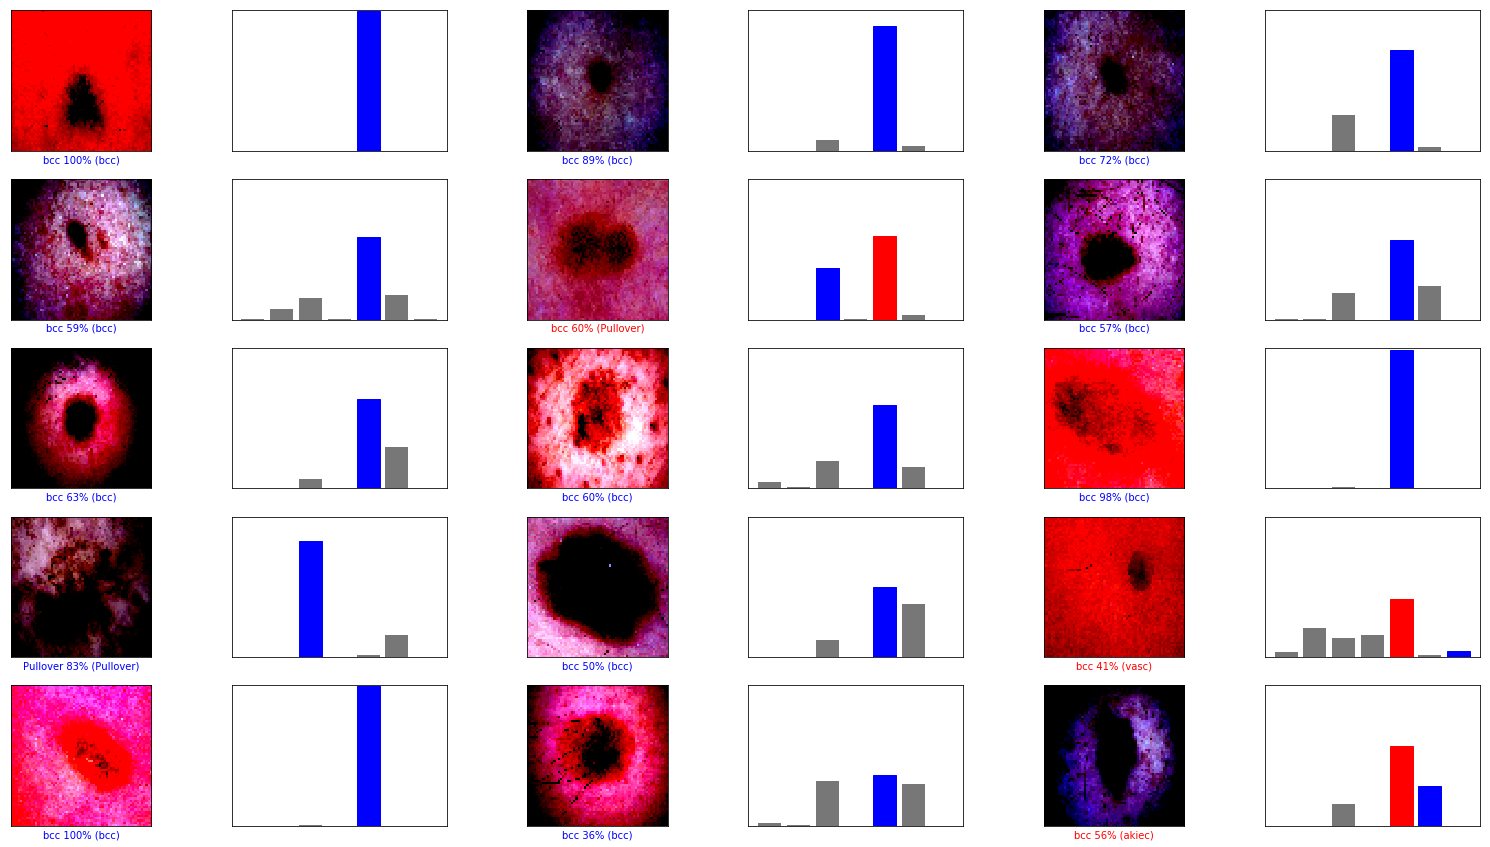

In [23]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(3*3*num_cols, 3*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, y_test_t, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, y_test_t)
plt.show()

In [24]:
img = x_test[0]
img = (np.expand_dims(img,0))


[[6.4922546e-07 4.1344725e-07 9.7619032e-04 1.6230012e-04 9.9871278e-01
  7.1834009e-05 7.5881231e-05]]


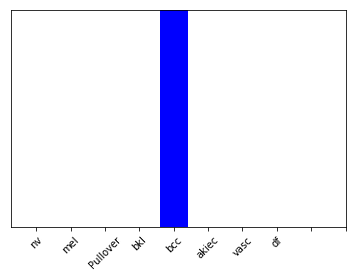

In [25]:
predictions_single = model_32.predict(img)

print(predictions_single)

plot_value_array(0, predictions_single, y_test_t)
_ = plt.xticks(range(10), class_names, rotation=45)